In [80]:
import re
import json
import pickle
import seaborn as sns
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import pomegranate as pg
from scipy.stats import chi2_contingency

%config InlineBackend.figure_format = 'svg'
split = 'test'
topk_paths = 30
num_states = 15
num_clusters = 150
agent_percent = 0.15
callback_thresh = 2
cluster_parent_dir = '/g/ssli/data/tmcalls/shared/tmobile/cluster_assignment/bert-base-uncased_mlm-lemax-merge-num2'
label_path = '/g/ssli/data/tmcalls/shared/tmobile/metadata/labels5.csv.gz'
ndf_path = '/g/ssli/data/tmcalls/roylu/stats_data/ndf2.pkl'
model_path = f'{cluster_parent_dir}/sshmm/agent_{num_clusters:03}/models/sshmm_{num_states:03}.json'
state_seq_dir = f'{cluster_parent_dir}/state_sequence/agent_{num_clusters:03}/state_{num_states:03}'
msa_path = f'/g/ssli/data/tmcalls/shared/tmobile/agent_info/msa_{agent_percent}.csv'
lsa_path = f'/g/ssli/data/tmcalls/shared/tmobile/agent_info/lsa_{agent_percent}.csv'

In [81]:
with open(model_path, 'r') as f:
    model = pg.HiddenMarkovModel.from_json(json.load(f))
    
idx2state = {}
for i, s in enumerate(model.states):
    idx2state[i] = s.name.split('<-')[0].strip()
    
assert len(idx2state) - 2 == num_states
    
print(f'# states = {len(idx2state)-2}')
print(f'# clusters = {num_clusters}')
df_path = f'{state_seq_dir}/agent_{split}.csv'
df = pd.read_csv(df_path, sep='|')

label_df = pd.read_csv(label_path, compression='gzip', sep='|')

with open(ndf_path, 'rb') as f:
    ndf = pickle.load(f)

# states = 15
# clusters = 150


In [82]:
C_sids = label_df[label_df.C != 'skip'].sourcemediaid.tolist()
ndf = ndf[ndf.sourcemediaid.isin(C_sids)]

In [83]:
ndf[f'{callback_thresh}_cb'] = ndf.adjusted_callback_period_days.apply(lambda x: 'ncb' if x > callback_thresh else 'cb')
vc = ndf[f'{callback_thresh}_cb'].value_counts()
overall_cb_ratio = vc['cb'] / sum(vc)

In [84]:
def collapse(x):
    chrs = ''.join([chr(int(xx)+97) for xx in x.strip().split(',')])
    collapsed_chrs = re.sub(r'(.)\1+', r'\1', chrs)
    collapsed_state_seq = ','.join([idx2state[ord(c)-97] for c in collapsed_chrs])
    return collapsed_state_seq

In [85]:
df['collapsed_state_sequence'] = df['state_sequence'].apply(lambda x: collapse(x))
selected_paths = df['collapsed_state_sequence'].value_counts()[:topk_paths].index.tolist()
pprint(selected_paths)

df = df[df['collapsed_state_sequence'].isin(selected_paths)]
df.rename(columns={'example_id': 'sourcemediaid'}, inplace=True)

['S01,S02,V03,S03',
 'S01,S02,V02,T01,S03',
 'S01,S02,T03,T05,T01,S03',
 'S01,S02,V05,T01,S03',
 'S01,V01,S03',
 'S01,S02,V06,T02,T01,S03',
 'S01,S02,V04,T01,S03',
 'S01,S02,V06,T01,S03',
 'S01,S02,T03,T04,T01,S03',
 'S01,S02,T03,T01,S03',
 'S01,S02,V03',
 'S01,S02,V03,T01,S03',
 'S01,S02,T03,T02,T01,S03',
 'S01,S02,T03,T05',
 'S01,S02,T03,T05,S03',
 'S01,S02,V06,T04,T01,S03',
 'S01,S02,V02,T02,T01,S03',
 'S01,S02,T03,T04',
 'S01,S02,T02,T01,S03',
 'S01,S02,V04,T02,T01,S03',
 'S01,S02,V07',
 'S01,S02,V05,T02,T01,S03',
 'S01,S02,T03,T05,T04,T01,S03',
 'S01,S02,T03,T05,T02,T01,S03',
 'S01,S02,T03,S03',
 'S01,V01',
 'S01,S02,V02,T01',
 'S01,S02,T03,T05,T01',
 'S01,S02,T03,T04,T02,T01,S03',
 'S01,S02,T03']


In [86]:
df = df.merge(ndf[['sourcemediaid', f'{callback_thresh}_cb']], how='left', on='sourcemediaid')

In [87]:
contigency = pd.crosstab(df['collapsed_state_sequence'], df['2_cb'])
c, p, dof, expected = chi2_contingency(contigency)
contigency_pct = pd.crosstab(df['collapsed_state_sequence'], df['2_cb'], normalize='index')
contigency_pct['cb_diff_percent'] = (contigency_pct['cb'] - overall_cb_ratio) / overall_cb_ratio * 100
cnt = contigency['cb'] + contigency['ncb']
cnt_df = pd.DataFrame(data=cnt.values, columns=['count'], index=cnt.index).reset_index()
contigency_pct = contigency_pct.merge(cnt_df, on='collapsed_state_sequence')
contigency_pct

,collapsed_state_sequence,cb,ncb,cb_diff_percent,count
0,"S01,S02,T02,T01,S03",0.066107,0.933893,-38.612587,953
1,"S01,S02,T03",0.259819,0.740181,141.269341,331
2,"S01,S02,T03,S03",0.216797,0.783203,101.318969,512
3,"S01,S02,T03,T01,S03",0.121534,0.878466,12.856917,4147
4,"S01,S02,T03,T02,T01,S03",0.073856,0.926144,-31.416650,1530
5,"S01,S02,T03,T04",0.148445,0.851555,37.847292,997
6,"S01,S02,T03,T04,T01,S03",0.089202,0.910798,-17.166564,5325
7,"S01,S02,T03,T04,T02,T01,S03",0.076712,0.923288,-28.764439,365
8,"S01,S02,T03,T05",0.206657,0.793343,91.903407,1442
9,"S01,S02,T03,T05,S03",0.157360,0.842640,46.125883,1182


In [88]:
contigency = contigency.reset_index()

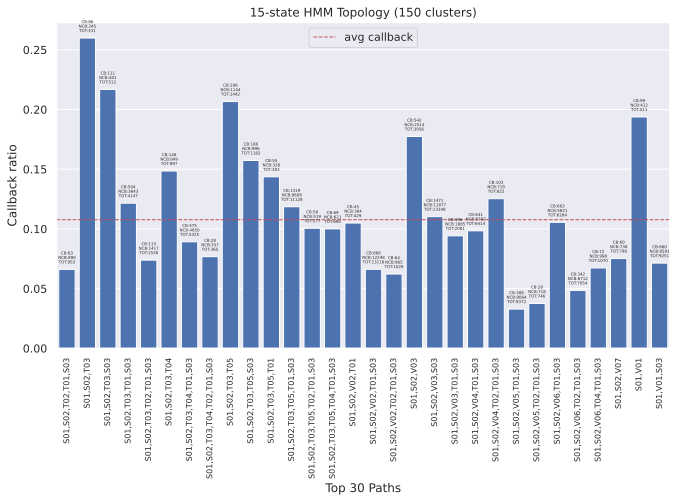

In [90]:
sns.set(rc={'figure.figsize':(11, 6)})

g = sns.barplot(
    x='collapsed_state_sequence',
    y='cb',
#    hue='callback',
    data=contigency_pct,
    color='b',
    #palette = 'husl',  
    capsize = 0.05,             
    saturation = 8,             
    errcolor = 'gray',
    errwidth = 2,  
    ci = 'sd'
)
g.set(
    title=f'{num_states}-state HMM Topology ({num_clusters} clusters)',
    xlabel=f'Top {topk_paths} Paths',
    ylabel='Callback ratio',
)
#g.xaxis.set_label_position('top') 

xticks = plt.xticks()[1]
for i, p in enumerate(g.patches):
    xtick = xticks[i%len(xticks)]._text
    row = contigency[contigency['collapsed_state_sequence'] == xtick]
    cb_cnt = row['cb'].tolist()[0]
    ncb_cnt = row['ncb'].tolist()[0]
    height = p.get_height()
    g.text(
        p.get_x()+p.get_width()/2.,
        height + 0.005, 
        f'CB:{cb_cnt}\nNCB:{ncb_cnt}\nTOT:{cb_cnt+ncb_cnt}',
        ha="center",
        size=4,
    )

# specifying horizontal line type
plt.axhline(y=overall_cb_ratio, color='r', linewidth=1, linestyle = 'dashed', label='avg callback')
#plt.axhline(y=msa_overall_cb_ratio, color='r', linewidth=1, linestyle = 'dashed', label='msa_overall')
#plt.axhline(y=lsa_overall_cb_ratio, color='g', linewidth=1, linestyle = 'dashed', label='lsa_overall')
plt.xticks(rotation=90, size=8)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1),
    fancybox=True,
    ncol=5,
)

In [91]:
cb_info_paths = []
for path, g in df.groupby('collapsed_state_sequence'):
    cb_info = g[f'{callback_thresh}_cb'].value_counts()
    cb_info_paths.append((cb_info['cb'], cb_info['ncb']))
    
c, p, dof, expected = chi2_contingency(cb_info_paths)
#cb_path_table = pd.DataFrame(cb_info_paths, columns=['path', 'cb', 'ncb'])
#print(cb_path_table)

In [92]:
msa = pd.read_csv(msa_path, sep='|')
lsa = pd.read_csv(lsa_path, sep='|')

m = msa.sourcemediaid.tolist()
l = lsa.sourcemediaid.tolist()
mdf = df[df.sourcemediaid.isin(m)]#.rename(columns={'example_id': 'sourcemediaid'})
ldf = df[df.sourcemediaid.isin(l)]#.rename(columns={'example_id': 'sourcemediaid'})
mdf = mdf.merge(msa[['sourcemediaid', 'agent_type']], on='sourcemediaid')
ldf = ldf.merge(lsa[['sourcemediaid', 'agent_type']], on='sourcemediaid')

/g/tial/transitory/roylu/miniconda3/envs/conv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [93]:
join_df = pd.concat([mdf, ldf])
print(join_df.agent_type.value_counts())

lsa_ncb    9679
msa_ncb    6262
lsa_cb     2018
msa_cb      123
Name: agent_type, dtype: int64


In [94]:
seq_dic = {}
seq2agent_cnt = {}
vc = join_df['agent_type'].value_counts()
msa_overall_cb_ratio = vc['msa_cb'] / sum([vc['msa_cb'], vc['msa_ncb']])
lsa_overall_cb_ratio = vc['lsa_cb'] / sum([vc['lsa_cb'], vc['lsa_ncb']])
for seq, g in join_df.groupby('collapsed_state_sequence'):
    dic = {}
    vc = g.agent_type.value_counts()
    if 'msa_cb' not in vc:
        vc['msa_cb'] = 0
    dic['msa'] = vc['msa_cb'] / sum([vc['msa_cb'], vc['msa_ncb']])
    dic['lsa'] = vc['lsa_cb'] / sum([vc['lsa_cb'], vc['lsa_ncb']])
    seq_dic[seq] = dic
        
    #seq2agent_cnt[seq] = {
    #    'msa': vc['msa_cb'] + vc['msa_ncb'],
    #    'lsa': vc['lsa_cb'] + vc['lsa_ncb'],
    #}
    seq2agent_cnt[seq] = vc.to_dict()

In [95]:
lst = []
seq2cnt = {}
for seq, cb2ratio in seq_dic.items():
    for cb, ratio in cb2ratio.items():
        lst.append((seq, cb, ratio))

df3 = pd.DataFrame(lst, columns=['path', 'callback', 'ratio'])

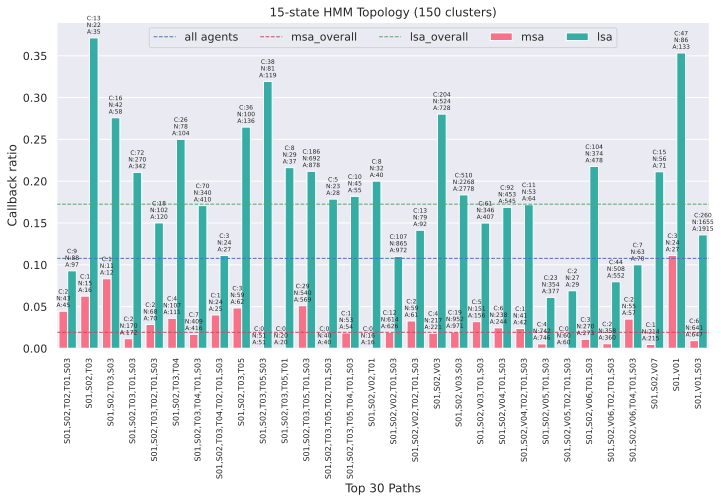

In [96]:
sns.set(rc={'figure.figsize':(11.7, 6)})

g = sns.barplot(
    x='path',
    y='ratio',
    hue='callback',
    data=df3,
    palette = 'husl',  
    capsize = 0.05,             
    saturation = 8,             
    errcolor = 'gray',
    errwidth = 2,  
    ci = 'sd'
)
g.set(
    title=f'{num_states}-state HMM Topology ({num_clusters} clusters)',
    xlabel=f'Top {topk_paths} Paths',
    ylabel='Callback ratio',
)
#g.xaxis.set_label_position('top') 

xticks = plt.xticks()[1]
for i, p in enumerate(g.patches):
    xtick = xticks[i%len(xticks)]._text
    agent2cnt = seq2agent_cnt[xtick]
    agent = {0: 'msa', 1: 'lsa'}[i//len(xticks)]
    cb_cnt = agent2cnt[f'{agent}_cb']
    ncb_cnt = agent2cnt[f'{agent}_ncb']
    height = p.get_height()
    g.text(
        p.get_x()+p.get_width()/2.,
        height + 0.005, 
        f'C:{cb_cnt}\nN:{ncb_cnt}\nA:{cb_cnt+ncb_cnt}',
        ha="center",size=6)
    
# specifying horizontal line type
plt.axhline(y=overall_cb_ratio, color='b', linewidth=1, linestyle = 'dashed', label='all agents')
plt.axhline(y=msa_overall_cb_ratio, color='r', linewidth=1, linestyle = 'dashed', label='msa_overall')
plt.axhline(y=lsa_overall_cb_ratio, color='g', linewidth=1, linestyle = 'dashed', label='lsa_overall')
plt.xticks(rotation=90, size=8)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1),
    fancybox=True,
    ncol=5,
)

In [71]:
# all possible paths
pprint(list(seq2agent_cnt.keys()))

['S01,S02,T02,T01,S03',
 'S01,S02,T03',
 'S01,S02,T03,S03',
 'S01,S02,T03,T01,S03',
 'S01,S02,T03,T02,T01,S03',
 'S01,S02,T03,T04',
 'S01,S02,T03,T04,T01,S03',
 'S01,S02,T03,T04,T02,T01,S03',
 'S01,S02,T03,T05',
 'S01,S02,T03,T05,S03',
 'S01,S02,T03,T05,T01',
 'S01,S02,T03,T05,T01,S03',
 'S01,S02,T03,T05,T02,T01,S03',
 'S01,S02,T03,T05,T04,T01,S03',
 'S01,S02,V02,T01',
 'S01,S02,V02,T01,S03',
 'S01,S02,V02,T02,T01,S03',
 'S01,S02,V03',
 'S01,S02,V03,S03',
 'S01,S02,V03,T01,S03',
 'S01,S02,V04,T01,S03',
 'S01,S02,V04,T02,T01,S03',
 'S01,S02,V05,T01,S03',
 'S01,S02,V05,T02,T01,S03',
 'S01,S02,V06,T01,S03',
 'S01,S02,V06,T02,T01,S03',
 'S01,S02,V06,T04,T01,S03',
 'S01,S02,V07',
 'S01,V01',
 'S01,V01,S03']


In [97]:
from collections import Counter, defaultdict
def r(df):
    ret = {}
    #for k in ['msa_cb', 'msa_ncb', 'lsa_cb', 'lsa_ncb']:
    for k in ['msa', 'lsa']:
        ret[k] = defaultdict(list)
        
    for s, a in df[['state_sequence', 'agent_type']].itertuples(index=False):
        s = list(map(int, s.split(',')))
        total = len(s)
        cnt = Counter(s)
        for state_idx, c in cnt.items():
            duration = c/total
            ret[a[:3]][state_idx].append(duration)
            #ret[a][state_idx].append(duration)

    for agent_type, state_idx2ratios in ret.items():
        for state_idx, ratios in list(state_idx2ratios.items()):
            state = idx2state[state_idx]
            ret[agent_type][state] = sum(ratios) / len(ratios)
            del ret[agent_type][state_idx]
            
    return ret

In [ ]:
# Select a path here
#selected_path = 'S01,S02,T03,T05,S03'
#selected_path = 'S01,S02,V06,T01,S03'
#selected_path = 'S01,S02,T03,T05,T04,T01,S03'
#selected_path = 'S01,S02,T03,T04,T02,T01,S03'
#selected_path = 'S01,S02,T03,S03'
#selected_path = 'S01,S02,T03,T04,T02,T01,S03'
#selected_path = 'S01,S02,T03,T05,T01,S03'
#selected_path = 'S01,S02,T03,T05,S03'
#selected_path = 'S01,S02,T03'
#selected_path = 'S01,V01,S03'
#selected_path = 'S01,S02,V05,T02,T01,S03' 
#selected_path = 'S01,V01'
#selected_path = 'S01,S02,T03,T05'
#selected_path = 'S01,S02,T03,S03' # PIN code; can't verify users
selected_path = 'S01,S02,V06,T02,T01,S03'

In [98]:


path_df = join_df[join_df['collapsed_state_sequence'] == selected_path]
path_msa = path_df[path_df['agent_type'].apply(lambda x: 'msa' in x)]
path_lsa = path_df[path_df['agent_type'].apply(lambda x: 'lsa' in x)]
path_join_df = pd.concat([path_msa, path_lsa])

dic = r(path_join_df)

lst = []
for agent_type, state2ratio in dic.items():
    for state, ratio in state2ratio.items():
        lst.append((agent_type, state, ratio))

df4 = pd.DataFrame(lst, columns=['agent_type', 'state', 'ratio'])

vc = path_join_df.agent_type.value_counts()

if 'msa_cb' not in vc:
    vc['msa_cb'] = 0
    
agent2cnt = {
    'msa': vc['msa_cb'] + vc['msa_ncb'],
    'lsa': vc['lsa_cb'] + vc['lsa_ncb'],
}

df4['agent_type'] = df4['agent_type'].apply(
    lambda x: f"{x} (cb:{vc[x+'_cb']} ncb:{vc[x+'_ncb']} total:{vc[x+'_cb']+vc[x+'_ncb']})"
)

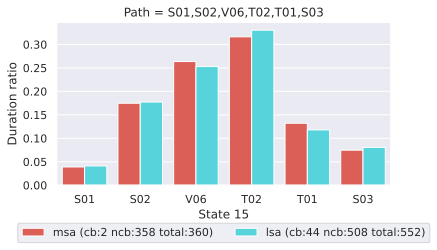

In [74]:
sns.set(rc={'figure.figsize':(6, 3)})

g = sns.barplot(
    x='state',
    y='ratio',
    hue='agent_type',
    data=df4,
    palette = 'hls',  
    capsize = 0.05,             
    saturation = 8,             
    errcolor = 'gray',
    errwidth = 2,  
    ci = 'sd'
)

g.set(
    title=f'Path = {selected_path}',
    xlabel=f'State {num_states}',
    ylabel='Duration ratio',
)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
    ncol=5,
)

In [99]:
# dataframe of selected path
# you can choose a sourcemediaid from here and use show_conversation.py to see the original conversations
path_df

,sourcemediaid,state_sequence,collapsed_state_sequence,2_cb,agent_type
26,257754363,"0,1,1,1,1,1,13,13,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...","S01,S02,V06,T02,T01,S03",cb,msa_cb
117,257919245,"0,1,1,1,1,1,1,13,13,13,4,4,4,4,4,4,4,4,4,4,4,4...","S01,S02,V06,T02,T01,S03",ncb,msa_ncb
142,258048867,"0,1,1,13,13,13,13,13,13,13,13,13,13,4,4,4,4,4,...","S01,S02,V06,T02,T01,S03",ncb,msa_ncb
213,258219563,"0,1,1,1,13,13,13,13,13,13,13,13,13,13,13,13,13...","S01,S02,V06,T02,T01,S03",ncb,msa_ncb
250,258338875,"0,1,1,1,1,1,1,1,1,13,4,4,4,4,4,4,4,4,3,2","S01,S02,V06,T02,T01,S03",ncb,msa_ncb
...,...,...,...,...,...
11652,265043044,"0,1,1,1,13,13,13,13,13,13,13,13,4,4,4,4,4,4,4,...","S01,S02,V06,T02,T01,S03",ncb,lsa_ncb
11656,265043588,"0,1,1,13,13,13,13,13,13,13,4,4,4,4,4,4,4,4,4,4...","S01,S02,V06,T02,T01,S03",ncb,lsa_ncb
11669,265057473,"0,1,1,1,1,1,13,13,13,13,13,4,4,4,4,4,4,4,3,3,3...","S01,S02,V06,T02,T01,S03",cb,lsa_cb
11689,265070499,"0,1,1,1,1,1,1,1,13,13,13,13,13,4,4,4,4,4,4,4,3...","S01,S02,V06,T02,T01,S03",ncb,lsa_ncb
